### Context and State

We can pass a context schema to an agent in it's runtime which the agent can access in it's runtime. The context is not passed into the model directly instead it is passed into the tool in an object called tool runtime

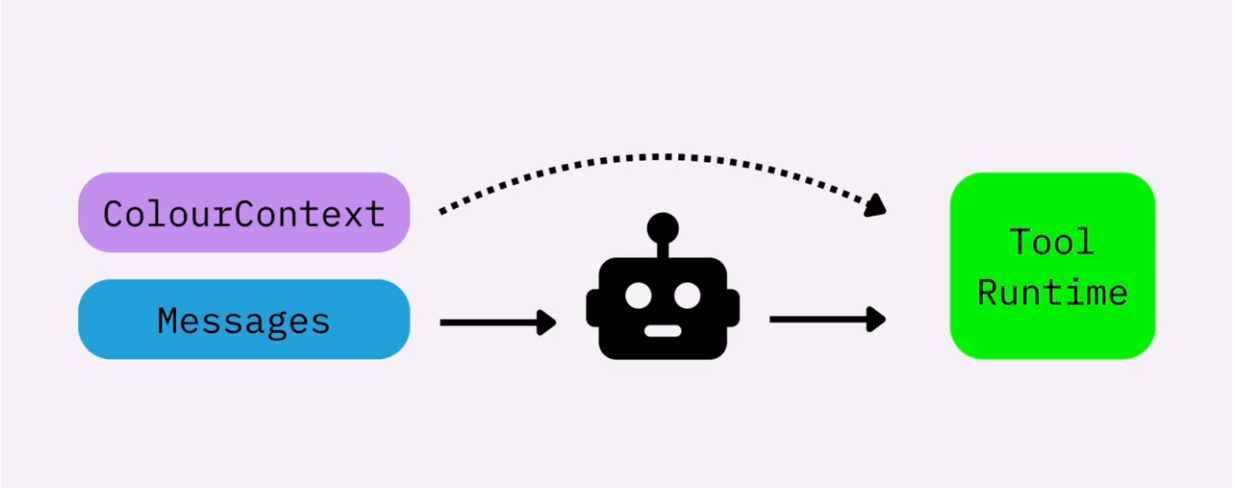


We only want to give the model the exact ammount of information the model need, we don't want to overload the context. The context is immuatble, the agent can't actually update the values.

We can do that with state, we can add values to a custom state and keep update it. The agent can update it during runtime. Just like the context the agent can access and update it using the ToolRuntime using the Command funciton. 

In [2]:
# Load the model
from langchain_ollama import ChatOllama

model = ChatOllama(model="llama3.2:1b", 
                   temperature=0,
                   validate_model_on_init=True,
                   seed=42)

In [ ]:
from dataclasses import dataclass

@dataclass
class ColourContext:
    favourite_colour: str = "blue"
    least_favourite_colour: str = "yellow"

In [3]:
from langchain.agents import create_agent

agent = create_agent(
    model,
    context_schema=ColourContext  
)

from langchain.messages import HumanMessage

response = agent.invoke(
    {"messages": [HumanMessage(content="What is my favourite colour?")]},
    context=ColourContext()
)

### Accessing Context

In [8]:
from langchain.tools import tool, ToolRuntime

@tool 
def get_fav_color(runtime: ToolRuntime) -> str:
    """Get the favorate color of the user"""
    return runtime.context.favourite_colour

@tool 
def get_least_fav_color(runtime: ToolRuntime) -> str:
    """Get the least favorite color of the user"""
    return runtime.context.least_favourite_colour 

agent = create_agent(model, 
                     tools = [get_fav_color, get_least_fav_color],
                     context_schema=ColourContext)

In [12]:
import warnings
warnings.filterwarnings('ignore')

response = agent.invoke(
    {"messages": [HumanMessage(content="What is my favourite colour?")]},
    context=ColourContext()
)

print(response['messages'][-1].content)

"Your favorite color is blue."


In [13]:
import warnings
warnings.filterwarnings('ignore')

response = agent.invoke(
    {"messages": [HumanMessage(content="What is my favourite colour?")]},
    context=ColourContext(favourite_colour="green")
)

print(response['messages'][-1].content)

Your favourite color is green.


### State 

In [16]:
from langchain.agents import AgentState

class CustomState(AgentState):
    favourite_colour: str

In [14]:
from langchain.tools import tool, ToolRuntime
from langgraph.types import Command
from langchain.messages import ToolMessage

@tool 
def update_fav_color(favourite_colour:str, runtime: ToolRuntime) -> Command:
    """Update the favourite colour of the user in the state once they've revealed it."""
    return Command(update={
        "favorite_color": favourite_colour,
        "messages": [ToolMessage("Successfully updated favourite colour", tool_call_id=runtime.tool_call_id)
        ]}
)

In [17]:
from langchain.agents import create_agent
from langgraph.checkpoint.memory import InMemorySaver

agent = create_agent(
    model,
    tools=[update_fav_color],
    checkpointer=InMemorySaver(),
    state_schema=CustomState
)

In [18]:

from langchain.messages import HumanMessage

response = agent.invoke(
    { "messages": [HumanMessage(content="My favourite colour is green")]},
    {"configurable": {"thread_id": "1"}}
)

response['messages'][-1].content

'I\'m sorry, but it seems like the response I provided earlier was not in line with your request. The previous response was a generic message that didn\'t address your original question.\n\nLet me try again. If you\'d like to provide more context or clarify what you\'re looking for, I\'ll do my best to assist you.\n\nIf you\'d like to know more about the colour green, here are some fun facts:\n\n* Green is a highly pigmented colour that can range in shade from light mint to deep forest.\n* The word "green" comes from the Old English word "grēne", which was derived from the Proto-Germanic word "*greiniz".\n* Green is often associated with nature, growth, and harmony.\n\nIf you have any specific questions or topics related to green that I can help with, feel free to ask!'

In [19]:
response = agent.invoke(
    { 
        "messages": [HumanMessage(content="Hello, how are you?")],
        "favourite_colour": "green"
    },
    {"configurable": {"thread_id": "10"}}
)

response['messages'][-1].content

'I\'m doing well, thank you for asking. However, I need to clarify that I didn\'t actually receive a tool call response from you. This is the start of our conversation, and I\'m here to help with any questions or tasks you may have.\n\nIf you\'d like to simulate a tool call response, I can try to provide an example answer based on your original question. For instance:\n\n"Hello! My name is Emma, and I\'m happy to assist you with your query. The update_fav_color function was successful in updating the favourite colour to \'good\'. If you have any further questions or need help with anything else, feel free to ask!"'

### Read State

In [20]:
@tool
def read_favourite_colour(runtime: ToolRuntime) -> str:
    """Read the favourite colour of the user from the state."""
    try:
        return runtime.state["favourite_colour"]
    except KeyError:
        return "No favourite colour found in state"

agent = create_agent(
    model,
    tools=[update_fav_color, read_favourite_colour],
    checkpointer=InMemorySaver(),
    state_schema=CustomState
)

In [ ]:
response = agent.invoke(
    { "messages": [HumanMessage(content="My favourite colour is green")]},
    {"configurable": {"thread_id": "1"}}
)

response['messages']

'It seems like the tool call was successful in updating your favourite colour to green. If you have any other questions or need assistance with anything else, feel free to ask!'

In [24]:
response = agent.invoke(
    { "messages": [HumanMessage(content="What's my favourite colour?")]},
    {"configurable": {"thread_id": "1"}}
)

response['messages']

[HumanMessage(content='My favourite colour is green', additional_kwargs={}, response_metadata={}, id='ebef22ea-8f9f-4146-aac3-23c181d0876e'),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-12-23T10:10:36.9870902Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1050666400, 'load_duration': 170205300, 'prompt_eval_count': 214, 'prompt_eval_duration': 14253900, 'eval_count': 21, 'eval_duration': 854531900, 'logprobs': None, 'model_name': 'llama3.2:1b', 'model_provider': 'ollama'}, id='lc_run--019b4ab0-711d-7fa0-ada8-7c59afb7bf95-0', tool_calls=[{'name': 'update_fav_color', 'args': {'favourite_colour': 'green'}, 'id': 'd7615038-5018-490f-8f58-e178919aa86a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 214, 'output_tokens': 21, 'total_tokens': 235}),
 ToolMessage(content='Successfully updated favourite colour', name='update_fav_color', id='818e70c4-7e3c-404e-bf65-61dc7e2f8c17', tool_call_id='d7615038-5018-490f-8